In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.lines import Line2D

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # ArviZ

az.style.use("arviz-doc")

In [3]:
rng = np.random.default_rng(121195)
N = 200
a, b = 0.5, 1.1
x = rng.uniform(-1.5, 1.5, N)
shape = np.exp(0.3 + x * 0.5 + rng.normal(scale=0.1, size=N))
y = rng.gamma(shape, np.exp(a + b * x) / shape, N)
data = pd.DataFrame({"x": x, "y": y})
new_data = pd.DataFrame({"x": np.linspace(-1.5, 1.5, num=50)})

In [4]:
formula = bmb.Formula("y ~ x")
model = bmb.Model(formula, data, family="gamma", link="log")
model

       Formula: y ~ x
        Family: gamma
          Link: mu = log
  Observations: 200
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 2.5037)
            x ~ Normal(mu: 0.0, sigma: 2.8025)
        
        Auxiliary parameters
            y_alpha ~ HalfCauchy(beta: 1.0)

In [5]:
idata = model.fit(random_seed=121195, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y_alpha, Intercept, x]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


In [6]:
model.predict(idata, kind="mean", data=new_data)
model.predict(idata, kind="pps", data=new_data)

qts = (
    az.extract(idata.posterior_predictive, var_names="y")
    .quantile([0.025, 0.975], "sample")
    .to_numpy()
)
mean = az.extract(idata.posterior_predictive, var_names="y").mean("sample").to_numpy()

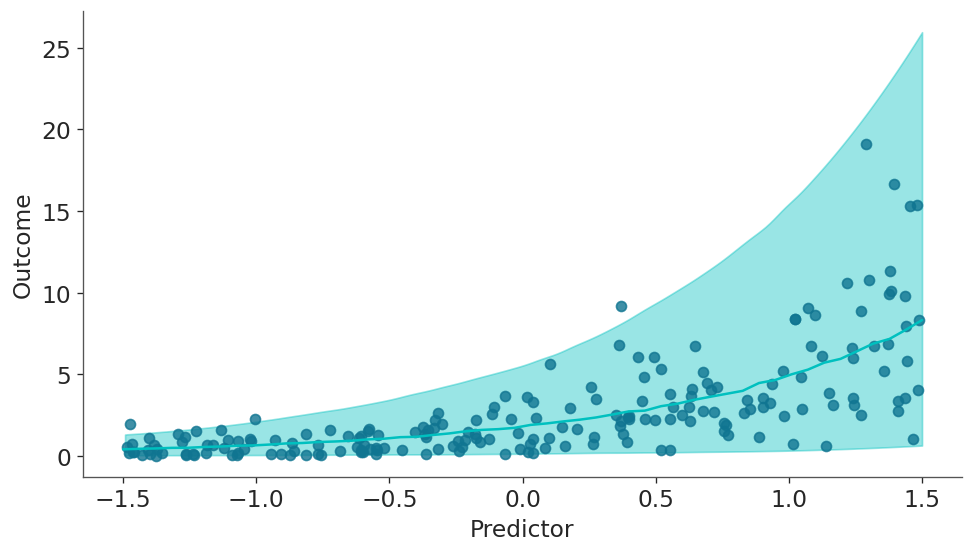

In [7]:
fig, ax = plt.subplots(figsize=(8, 4.5), dpi=120)

az.plot_hdi(new_data["x"], qts, ax=ax, fill_kwargs={"alpha": 0.4})
ax.plot(new_data["x"], mean, color="C1")
ax.scatter(data["x"], data["y"], alpha=0.8)
ax.set(xlabel="Predictor", ylabel="Outcome");

In [8]:
formula = bmb.Formula("y ~ x", "alpha ~ x")
model = bmb.Model(formula, data, family="gamma")
model

       Formula: y ~ x
                alpha ~ x
        Family: gamma
          Link: mu = log
                alpha = log
  Observations: 200
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 2.5037)
            x ~ Normal(mu: 0.0, sigma: 2.8025)
    target = alpha
        Common-level effects
            alpha_Intercept ~ Normal(mu: 0.0, sigma: 1.0)
            alpha_x ~ Normal(mu: 0.0, sigma: 1.0)

The default link for the `mu` parameter is the **inverse** function. We want to use the **log** function instead. So let's set the link functions manually.

In [9]:
formula = bmb.Formula("y ~ x", "alpha ~ x")
model = bmb.Model(formula, data, family="gamma", link={"mu": "log", "alpha": "log"})
model

       Formula: y ~ x
                alpha ~ x
        Family: gamma
          Link: mu = log
                alpha = log
  Observations: 200
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 2.5037)
            x ~ Normal(mu: 0.0, sigma: 2.8025)
    target = alpha
        Common-level effects
            alpha_Intercept ~ Normal(mu: 0.0, sigma: 1.0)
            alpha_x ~ Normal(mu: 0.0, sigma: 1.0)

In [10]:
formula = bmb.Formula("y ~ x", "alpha ~ x")
model = bmb.Model(formula, data, family="gamma", link={"mu": "log", "alpha": "log"})
model

       Formula: y ~ x
                alpha ~ x
        Family: gamma
          Link: mu = log
                alpha = log
  Observations: 200
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 2.5037)
            x ~ Normal(mu: 0.0, sigma: 2.8025)
    target = alpha
        Common-level effects
            alpha_Intercept ~ Normal(mu: 0.0, sigma: 1.0)
            alpha_x ~ Normal(mu: 0.0, sigma: 1.0)

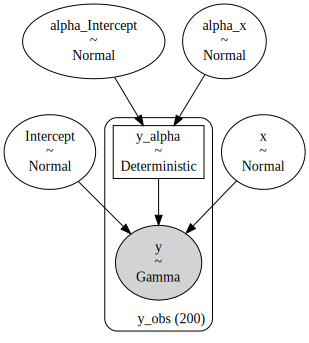

In [11]:
model.build()
model.graph()

In [12]:
idata_d = model.fit(tune=1000, draws=1000, random_seed=121195, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, x, alpha_Intercept, alpha_x]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


In [13]:
model.predict(idata_d, kind="mean")
model.predict(idata_d, kind="pps")

In [14]:
model.predict(idata_d, kind="mean", data=new_data)
model.predict(idata_d, kind="pps", data=new_data)

qts = (
    az.extract(idata.posterior_predictive, var_names="y")
    .quantile([0.025, 0.975], "sample")
    .to_numpy()
)
mean = az.extract(idata.posterior_predictive, var_names="y").mean("sample").to_numpy()

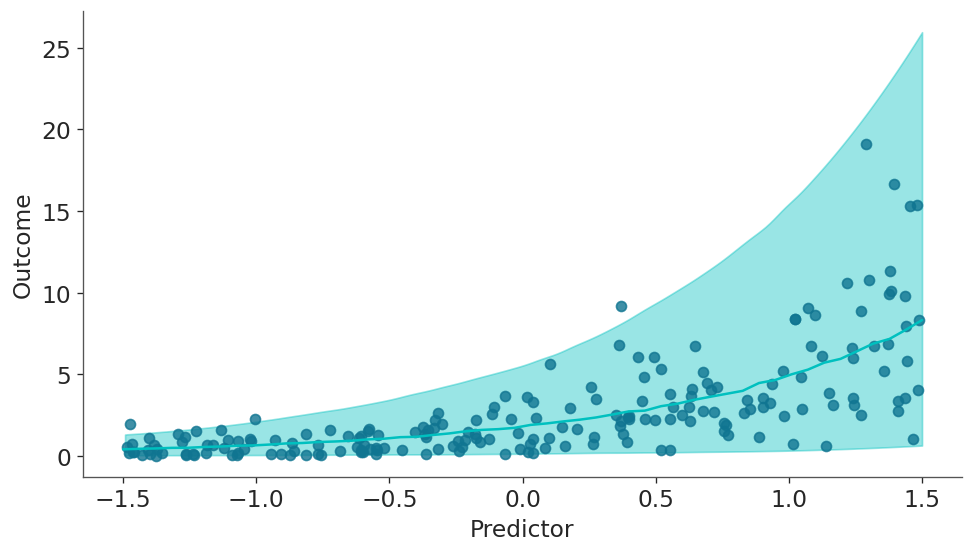

In [15]:
fig, ax = plt.subplots(figsize=(8, 4.5), dpi=120)

az.plot_hdi(new_data["x"], qts, ax=ax, fill_kwargs={"alpha": 0.4})
ax.plot(new_data["x"], mean, color="C1")
ax.scatter(data["x"], data["y"], alpha=0.8)
ax.set(xlabel="Predictor", ylabel="Outcome");

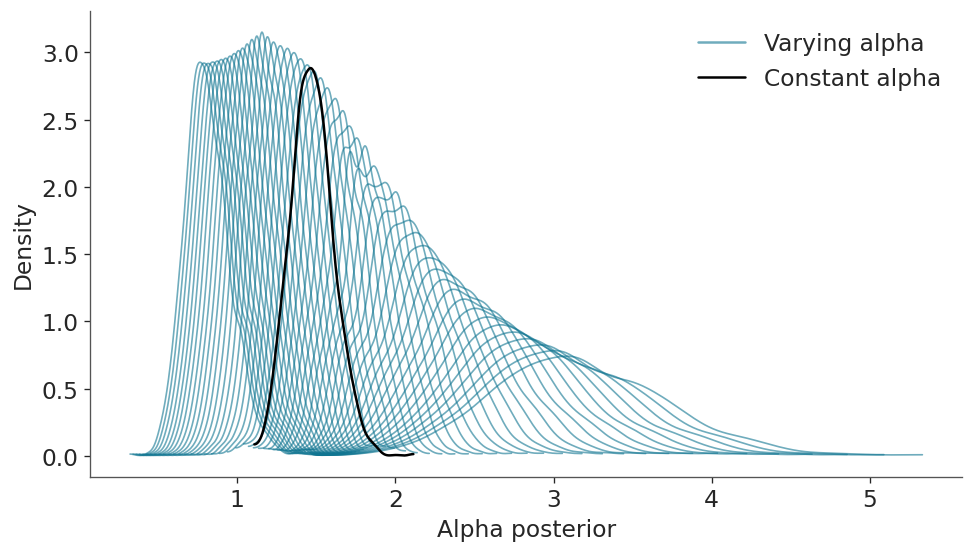

In [16]:
fig, ax = plt.subplots(figsize=(8, 4.5), dpi=120)

for idx in idata_d.posterior.coords.get("y_obs"):
    values = idata_d.posterior["y_alpha"].sel(y_obs=idx).to_numpy().flatten()
    grid, pdf = az.kde(values)
    ax.plot(grid, pdf, lw=1, color="C0", alpha=0.6)

values = idata.posterior["y_alpha"].to_numpy().flatten()
grid, pdf = az.kde(values)
ax.plot(grid, pdf, lw=1.5, color="black");

# Create legend
handles = [
    Line2D([0], [0], label="Varying alpha", lw=1.5, color="C0", alpha=0.6),
    Line2D([0], [0], label="Constant alpha", lw=1.5, color="black")
]

legend = ax.legend(handles=handles, loc="upper right", fontsize=14)

ax.set(xlabel="Alpha posterior", ylabel="Density");

In [17]:
az.compare({"constant": idata, "varying": idata_d})

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
varying,0,-309.048566,3.697041,0.000000,0.943171,16.440638,0.000000,False,log
constant,1,-318.913528,2.958351,9.864962,0.056829,15.832033,4.552608,False,log


## Gaussian response

In [18]:
data = bmb.load_data("bikes")
data.sort_values(by="hour", inplace=True)
data_cnt_om = data["count"].mean()
data_cnt_os = data["count"].std()
data["count_normalized"] = (data["count"] - data_cnt_om) / data_cnt_os
# Remove data, you may later try to refit the model to the whole data
data = data[::50]
data = data.reset_index(drop=True)

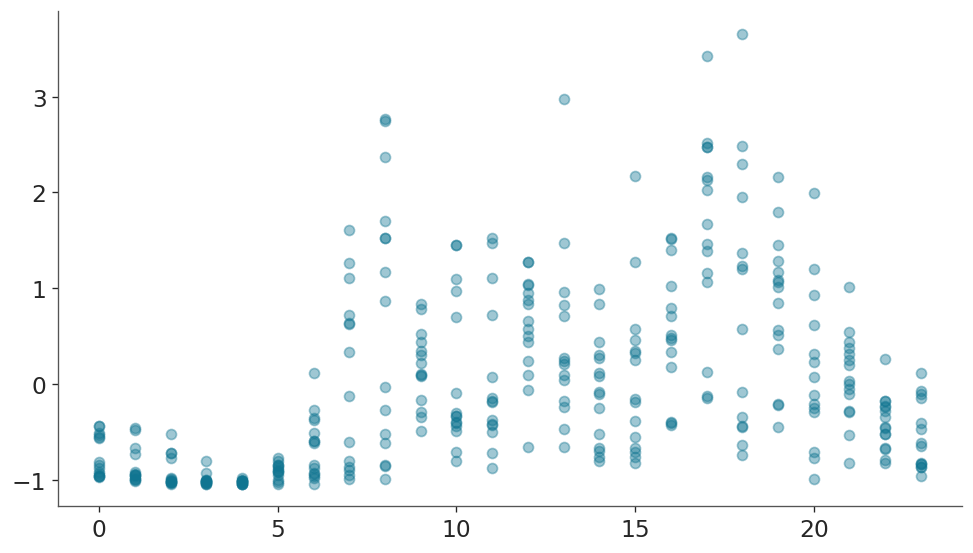

In [19]:
fig, ax = plt.subplots(figsize=(8, 4.5), dpi=120)
ax.scatter(data["hour"], data["count_normalized"], alpha=0.4);

In [20]:
knots = np.linspace(0, 23, 8)[1:-1]
model = bmb.Model("count_normalized ~ 0 + bs(hour, knots=knots, intercept=True)", data)
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [count_normalized_sigma, bs(hour, knots = knots, intercept = True)]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


In [21]:
hour = np.linspace(0, 23, num=200)
new_data = pd.DataFrame({"hour": hour})
model.predict(idata, data=new_data, kind="pps")

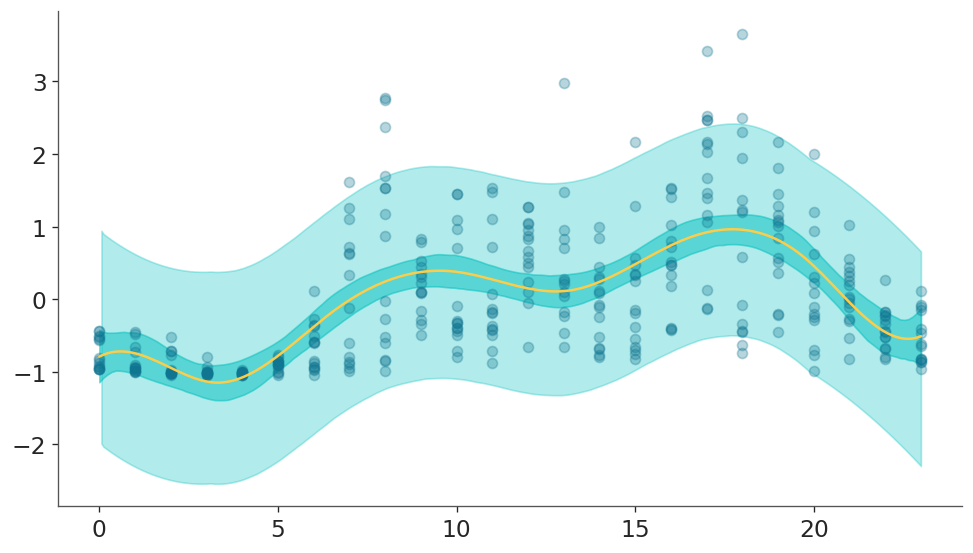

In [22]:
q = [0.025, 0.975]
dims = ("chain", "draw")

mean = idata.posterior["count_normalized_mean"].mean(dims).to_numpy()
mean_interval = idata.posterior["count_normalized_mean"].quantile(q, dims).to_numpy()
y_interval = idata.posterior_predictive["count_normalized"].quantile(q, dims).to_numpy()

fig, ax = plt.subplots(figsize=(8, 4.5), dpi=120)
ax.scatter(data["hour"], data["count_normalized"], alpha=0.3, color="C0", zorder=5)
ax.plot(hour, mean, color="C3", zorder=5)
ax.fill_between(hour, mean_interval[0],mean_interval[1], alpha=0.5, color="C1");
az.plot_hdi(hour, y_interval, fill_kwargs={"color": "C1", "alpha": 0.3}, ax=ax);

In [23]:
knots = np.linspace(0, 23, 8)[1:-1]
knots_s = np.linspace(0, 23, 5)[1:-1]
formula = bmb.Formula(
    "count_normalized ~ 0 + bs(hour, knots=knots, intercept=True)",
    "sigma ~ 0 + bs(hour, knots=knots_s, intercept=True)"
)
model = bmb.Model(formula, data)
model

       Formula: count_normalized ~ 0 + bs(hour, knots=knots, intercept=True)
                sigma ~ 0 + bs(hour, knots=knots_s, intercept=True)
        Family: gaussian
          Link: mu = identity
                sigma = log
  Observations: 348
        Priors: 
    target = mu
        Common-level effects
            bs(hour, knots = knots, intercept = True) ~ Normal(mu: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], sigma:
                [11.4095 14.9753 13.1114 11.0946 11.0908 11.0686 11.0843 12.9942 14.7908
             11.7213])
    target = sigma
        Common-level effects
            sigma_bs(hour, knots = knots_s, intercept = True) ~ Normal(mu: 0.0, sigma: 1.0)

In [24]:
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bs(hour, knots = knots, intercept = True), sigma_bs(hour, knots = knots_s, intercept = True)]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.


In [25]:
model.predict(idata, data=new_data, kind="pps")

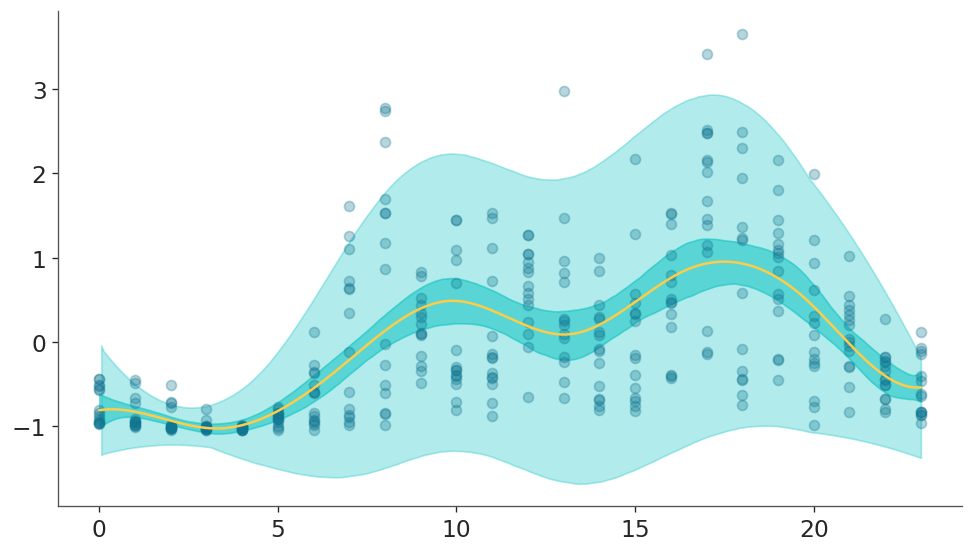

In [26]:
q = [0.025, 0.975]
dims = ("chain", "draw")

mean = idata.posterior["count_normalized_mean"].mean(dims).to_numpy()
mean_interval = idata.posterior["count_normalized_mean"].quantile(q, dims).to_numpy()
y_interval = idata.posterior_predictive["count_normalized"].quantile(q, dims).to_numpy()

fig, ax = plt.subplots(figsize=(8, 4.5), dpi=120)
ax.scatter(data["hour"], data["count_normalized"], alpha=0.3, color="C0", zorder=5)
ax.plot(hour, mean, color="C3", zorder=5)
ax.fill_between(hour, mean_interval[0],mean_interval[1], alpha=0.5, color="C1");
az.plot_hdi(hour, y_interval, fill_kwargs={"color": "C1", "alpha": 0.3}, ax=ax);

In [27]:
knots = np.linspace(0, 23, 8)[1:-1]
knots_s = np.linspace(0, 23, 5)[1:-1]
formula = bmb.Formula(
    "count ~ 0 + bs(hour, knots=knots, intercept=True)",
    "alpha ~ 0 + bs(hour, knots=knots_s, intercept=True)"
)
model = bmb.Model(formula, data, family="gamma", link={"mu": "log", "alpha": "log"})
model

       Formula: count ~ 0 + bs(hour, knots=knots, intercept=True)
                alpha ~ 0 + bs(hour, knots=knots_s, intercept=True)
        Family: gamma
          Link: mu = log
                alpha = log
  Observations: 348
        Priors: 
    target = mu
        Common-level effects
            bs(hour, knots = knots, intercept = True) ~ Normal(mu: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], sigma:
                [11.877  15.5889 13.6486 11.5492 11.5453 11.5221 11.5385 13.5266 15.3968
             12.2016])
    target = alpha
        Common-level effects
            alpha_bs(hour, knots = knots_s, intercept = True) ~ Normal(mu: 0.0, sigma: 1.0)

In [28]:
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bs(hour, knots = knots, intercept = True), alpha_bs(hour, knots = knots_s, intercept = True)]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


In [29]:
model.predict(idata, data=new_data, kind="pps")

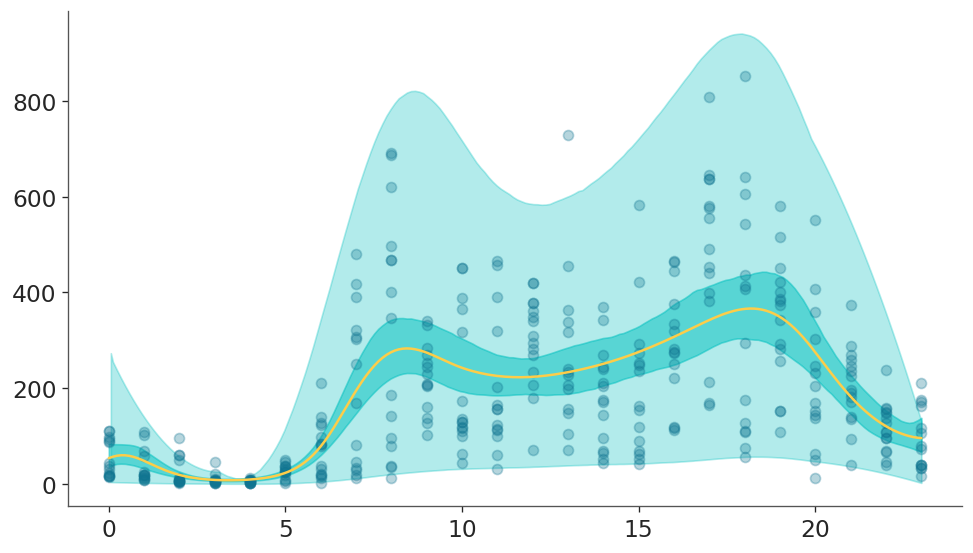

In [30]:
q = [0.025, 0.975]
dims = ("chain", "draw")

mean = idata.posterior["count_mean"].mean(dims).to_numpy()
mean_interval = idata.posterior["count_mean"].quantile(q, dims).to_numpy()
y_interval = idata.posterior_predictive["count"].quantile(q, dims).to_numpy()

fig, ax = plt.subplots(figsize=(8, 4.5), dpi=120)
ax.scatter(data["hour"], data["count"], alpha=0.3, color="C0", zorder=5)
ax.plot(hour, mean, color="C3", zorder=5)
ax.fill_between(hour, mean_interval[0],mean_interval[1], alpha=0.5, color="C1");
az.plot_hdi(hour, y_interval, fill_kwargs={"color": "C1", "alpha": 0.3}, ax=ax);

In [31]:
formula = bmb.Formula(
    "count ~ 0 + bs(hour, 8, intercept=True)",
    "alpha ~ 0 + bs(hour, 8, intercept=True)"
)
model = bmb.Model(formula, data, family="gamma", link={"mu": "log", "alpha": "log"})
model

       Formula: count ~ 0 + bs(hour, 8, intercept=True)
                alpha ~ 0 + bs(hour, 8, intercept=True)
        Family: gamma
          Link: mu = log
                alpha = log
  Observations: 348
        Priors: 
    target = mu
        Common-level effects
            bs(hour, 8, intercept = True) ~ Normal(mu: [0. 0. 0. 0. 0. 0. 0. 0.], sigma: [11.5837 13.5306
                12.1425 10.7098 10.6914 12.0893 13.4172 11.86  ])

    target = alpha
        Common-level effects
            alpha_bs(hour, 8, intercept = True) ~ Normal(mu: 0.0, sigma: 1.0)

In [32]:
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bs(hour, 8, intercept = True), alpha_bs(hour, 8, intercept = True)]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


In [33]:
model.predict(idata, data=new_data, kind="pps")

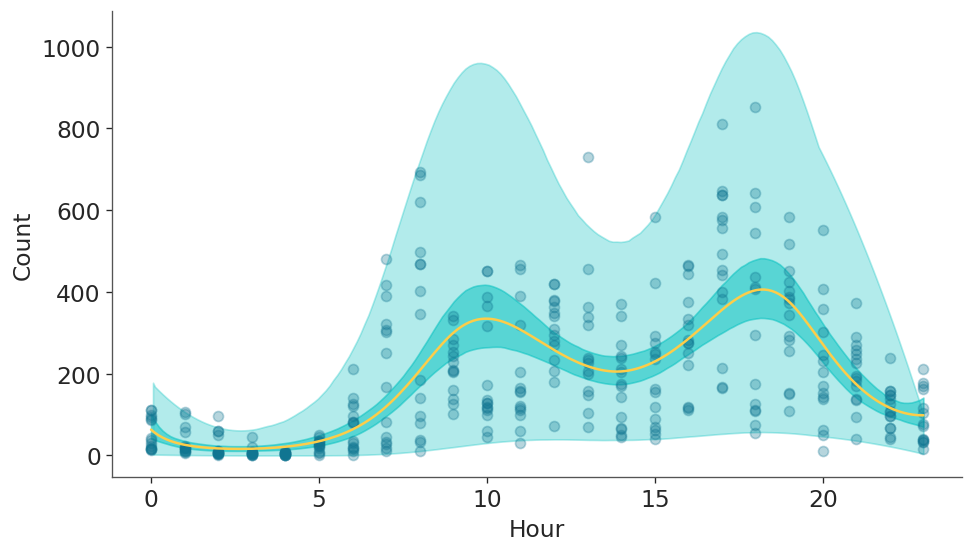

In [34]:
q = [0.025, 0.975]
dims = ("chain", "draw")

mean = idata.posterior["count_mean"].mean(dims).to_numpy()
mean_interval = idata.posterior["count_mean"].quantile(q, dims).to_numpy()
y_interval = idata.posterior_predictive["count"].quantile(q, dims).to_numpy()

fig, ax = plt.subplots(figsize=(8, 4.5), dpi=120)
ax.scatter(data["hour"], data["count"], alpha=0.3, color="C0", zorder=5)
ax.plot(hour, mean, color="C3", zorder=5)
ax.fill_between(hour, mean_interval[0],mean_interval[1], alpha=0.5, color="C1");
az.plot_hdi(hour, y_interval, fill_kwargs={"color": "C1", "alpha": 0.3}, ax=ax);

ax.set(xlabel="Hour", ylabel="Count");

In [35]:
data2 = data.loc[(data["hour"] < 10) | (data["hour"] > 15)]
formula = bmb.Formula(
    "count ~ 0 + bs(hour, 8, intercept=True)",
    "alpha ~ 0 + bs(hour, 8, intercept=True)"
)
model = bmb.Model(formula, data, family="gamma", link={"mu": "log", "alpha": "log"})
idata = model.fit()
model.predict(idata, data=new_data, kind="pps")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bs(hour, 8, intercept = True), alpha_bs(hour, 8, intercept = True)]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.


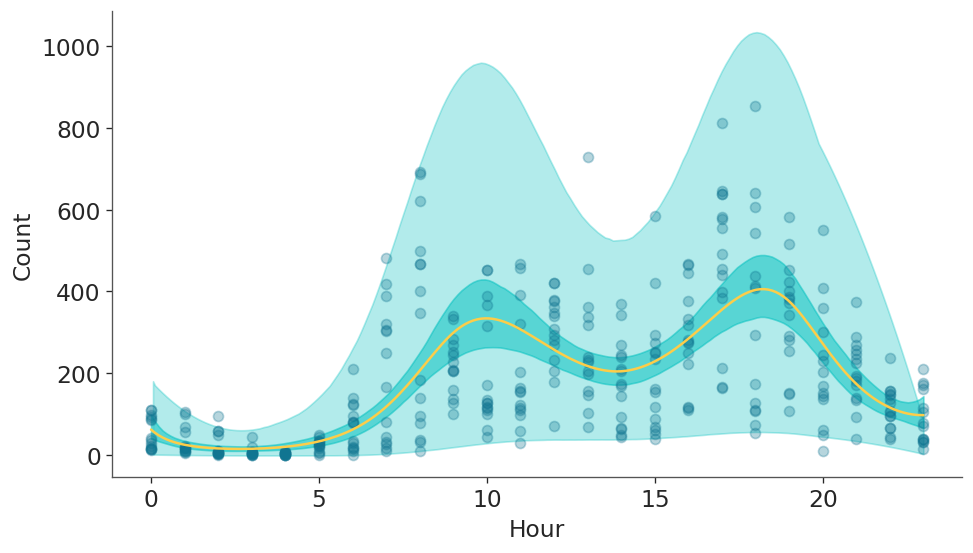

In [36]:
q = [0.025, 0.975]
dims = ("chain", "draw")

mean = idata.posterior["count_mean"].mean(dims).to_numpy()
mean_interval = idata.posterior["count_mean"].quantile(q, dims).to_numpy()
y_interval = idata.posterior_predictive["count"].quantile(q, dims).to_numpy()

fig, ax = plt.subplots(figsize=(8, 4.5), dpi=120)
ax.scatter(data["hour"], data["count"], alpha=0.3, color="C0", zorder=5)
ax.plot(hour, mean, color="C3", zorder=5)
ax.fill_between(hour, mean_interval[0],mean_interval[1], alpha=0.5, color="C1");
az.plot_hdi(hour, y_interval, fill_kwargs={"color": "C1", "alpha": 0.3}, ax=ax);

ax.set(xlabel="Hour", ylabel="Count");